In [1]:
# %%
import os
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Dict, List, Iterable

import io
import time
import numpy as np
import pandas as pd
import requests
from PIL import Image
from datasets import load_dataset

# %%
@dataclass
class PixmoQAMixConfig:
    seed: int = 42

    # Where to save the final parquet
    root_dir: Path = Path(".").resolve()
    out_dir: Path = root_dir / "data" / "final_dataset" / "pixmo"
    out_parquet_name: str = "pixmo_qa_mixed_with_bytes.parquet"

    # Max samples per source (None = all)
    max_cap_qa: Optional[int] = 8000
    max_ask_anything: Optional[int] = 4000
    max_point_explanations: Optional[int] = 2000
    max_count: Optional[int] = 2000
    max_docs: Optional[int] = 1000   # you can lower or set to 0 to skip

    # Shuffle final dataframe?
    shuffle: bool = True

    # Image download options
    request_timeout: int = 10
    max_retries: int = 3
    sleep_between_retries: float = 0.5  # seconds
    verify_ssl: bool = True

    # Optional resizing (set to None to keep original)
    image_size: Optional[int] = None  # e.g. 256 for square; None = no resize
    
    num_workers: int = 8
    oversample_factor: int = 3  # how many extra candidates to submit to handle failures



cfg = PixmoQAMixConfig()
cfg.out_dir.mkdir(parents=True, exist_ok=True)
cfg


PixmoQAMixConfig(seed=42, root_dir=PosixPath('/Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base'), out_dir=PosixPath('/Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base/data/final_dataset/pixmo'), out_parquet_name='pixmo_qa_mixed_with_bytes.parquet', max_cap_qa=8000, max_ask_anything=4000, max_point_explanations=2000, max_count=2000, max_docs=1000, shuffle=True, request_timeout=10, max_retries=3, sleep_between_retries=0.5, verify_ssl=True, image_size=None, num_workers=8, oversample_factor=3)

In [2]:
# %%
rng = np.random.default_rng(cfg.seed)

def download_image_to_bytes(
    url: str,
    timeout: int = 10,
    max_retries: int = 3,
    sleep_between: float = 0.5,
    verify_ssl: bool = True,
    resize_to: Optional[int] = None,
) -> Optional[bytes]:
    """
    Download image from URL and return raw bytes.
    Optionally resize to a square (resize_to x resize_to).
    Returns None on failure.
    """
    if not url:
        return None

    for attempt in range(max_retries):
        try:
            resp = requests.get(url, timeout=timeout, verify=verify_ssl)
            resp.raise_for_status()
            data = resp.content

            # Validate & optionally resize via PIL
            img = Image.open(io.BytesIO(data)).convert("RGB")

            if resize_to is not None:
                img = img.resize((resize_to, resize_to), Image.BILINEAR)
                buf = io.BytesIO()
                img.save(buf, format="JPEG")
                data = buf.getvalue()

            return data

        except Exception as e:
            if attempt == max_retries - 1:
                # print or log if you want more detail
                # print(f"[WARN] Failed to fetch {url}: {e}")
                return None
            time.sleep(sleep_between)
    return None


In [3]:
# %%
from typing import Callable

RowBuilder = Callable[[Dict, bytes], Optional[Dict]]


# %%
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Add this to your config dataclass if not already there:

def _download_and_build_row_thread(
    ex: Dict,
    row_builder: RowBuilder,
    cfg: PixmoQAMixConfig,
) -> Optional[Dict]:
    """Worker: download one image + build one row. Returns None on failure."""
    url = ex.get("image_url")
    img_bytes = download_image_to_bytes(
        url,
        timeout=cfg.request_timeout,
        max_retries=cfg.max_retries,
        sleep_between=cfg.sleep_between_retries,
        verify_ssl=cfg.verify_ssl,
        resize_to=cfg.image_size,
    )
    if img_bytes is None:
        return None
    return row_builder(ex, img_bytes)


def collect_stream_with_bytes(
    ds_stream: Iterable[Dict],
    max_samples: Optional[int],
    source_name: str,
    row_builder: RowBuilder,
    cfg: PixmoQAMixConfig,
) -> pd.DataFrame:
    """
    Parallel version (thread pool) for streaming HF dataset:
    - Submits download tasks to a ThreadPoolExecutor
    - Uses tqdm to show progress
    - Stops after collecting max_samples successful rows
    """

    if max_samples is None:
        # You *can* support None, but it's dangerous for streaming.
        # Better to force a number; here we'll just pick a large cap.
        max_samples = 10_000

    # We'll submit more tasks than max_samples to cover failures
    submit_cap = max_samples * getattr(cfg, "oversample_factor", 3)

    rows: List[Dict] = []
    futures = []
    n_seen = 0

    print(f"[{source_name}] Submitting up to {submit_cap} download tasks...")

    with ThreadPoolExecutor(max_workers=getattr(cfg, "num_workers", 8)) as executor:
        # 1. Submit tasks while streaming
        for ex in ds_stream:
            if len(futures) >= submit_cap:
                break
            n_seen += 1
            fut = executor.submit(_download_and_build_row_thread, ex, row_builder, cfg)
            futures.append(fut)

        print(f"[{source_name}] Submitted {len(futures)} tasks (seen {n_seen} examples).")

        # 2. Collect results with tqdm
        with tqdm(total=len(futures), desc=f"Downloading [{source_name}]", unit="sample") as pbar:
            for fut in as_completed(futures):
                result = fut.result()
                pbar.update(1)

                if result is None:
                    continue

                rows.append(result)

                # Stop early if we've collected enough
                if len(rows) >= max_samples:
                    pbar.set_postfix({"collected": len(rows)})
                    break

                if len(rows) % 500 == 0:
                    pbar.set_postfix({"collected": len(rows)})

    print(f"[{source_name}] Completed: {len(rows)} collected (target {max_samples}, seen {n_seen}).")
    return pd.DataFrame(rows)


In [4]:
# %%
def load_pixmo_cap_qa_streaming(cfg: PixmoQAMixConfig) -> pd.DataFrame:
    ds_stream = load_dataset(
        "allenai/pixmo-cap-qa",
        split="train",
        streaming=True,
    )

    def build_row(ex: Dict, img_bytes: bytes) -> Dict:
        return {
            "image_url": ex.get("image_url"),
            "image_sha256": ex.get("image_sha256"),
            "image_bytes": img_bytes,
            "question": ex.get("question"),
            "answer": ex.get("answer"),
            "source": "pixmo-cap-qa",
        }

    return collect_stream_with_bytes(
        ds_stream,
        max_samples=cfg.max_cap_qa,
        source_name="pixmo-cap-qa",
        row_builder=build_row,
        cfg=cfg,
    )


def load_pixmo_ask_anything_streaming(cfg: PixmoQAMixConfig) -> pd.DataFrame:
    ds_stream = load_dataset(
        "allenai/pixmo-ask-model-anything",
        split="train",
        streaming=True,
    )

    def build_row(ex: Dict, img_bytes: bytes) -> Dict:
        return {
            "image_url": ex.get("image_url"),
            "image_sha256": ex.get("image_sha256"),
            "image_bytes": img_bytes,
            "question": ex.get("question"),
            "answer": ex.get("answer"),
            "source": "pixmo-ask-model-anything",
        }

    return collect_stream_with_bytes(
        ds_stream,
        max_samples=cfg.max_ask_anything,
        source_name="pixmo-ask-model-anything",
        row_builder=build_row,
        cfg=cfg,
    )


def load_pixmo_point_explanations_streaming(cfg: PixmoQAMixConfig) -> pd.DataFrame:
    ds_stream = load_dataset(
        "allenai/pixmo-point-explanations",
        split="train",
        streaming=True,
    )

    def build_row(ex: Dict, img_bytes: bytes) -> Dict:
        return {
            "image_url": ex.get("image_url"),
            "image_sha256": ex.get("image_sha256"),
            "image_bytes": img_bytes,
            "question": ex.get("question"),
            # some versions may have 'answer' or 'explanation'
            "answer": ex.get("answer") or ex.get("explanation"),
            "source": "pixmo-point-explanations",
        }

    return collect_stream_with_bytes(
        ds_stream,
        max_samples=cfg.max_point_explanations,
        source_name="pixmo-point-explanations",
        row_builder=build_row,
        cfg=cfg,
    )


def load_pixmo_count_streaming(cfg: PixmoQAMixConfig) -> pd.DataFrame:
    ds_stream = load_dataset(
        "allenai/pixmo-count",
        split="train",
        streaming=True,
    )

    def build_row(ex: Dict, img_bytes: bytes) -> Dict:
        return {
            "image_url": ex.get("image_url"),
            "image_sha256": ex.get("image_sha256"),
            "image_bytes": img_bytes,
            "question": ex.get("question"),
            "answer": ex.get("answer"),
            "source": "pixmo-count",
        }

    return collect_stream_with_bytes(
        ds_stream,
        max_samples=cfg.max_count,
        source_name="pixmo-count",
        row_builder=build_row,
        cfg=cfg,
    )


def load_pixmo_docs_streaming(cfg: PixmoQAMixConfig) -> pd.DataFrame:
    """
    allenai/pixmo-docs has configs: 'charts', 'diagrams', 'other', 'tables'.
    Here we just use 'charts'. You can loop over them if you want more variety.
    """
    ds_stream = load_dataset(
        "allenai/pixmo-docs",
        "charts",
        split="train",
        streaming=True,
    )

    def build_row(ex: Dict, img_bytes: bytes) -> Dict:
        return {
            "image_url": ex.get("image_url"),
            "image_sha256": ex.get("image_sha256"),
            "image_bytes": img_bytes,
            "question": ex.get("question"),
            "answer": ex.get("answer"),
            "source": "pixmo-docs-charts",
        }

    return collect_stream_with_bytes(
        ds_stream,
        max_samples=cfg.max_docs,
        source_name="pixmo-docs-charts",
        row_builder=build_row,
        cfg=cfg,
    )


In [9]:
# %%
all_dfs: List[pd.DataFrame] = []

In [10]:
print("Loading pixmo-count (streaming + bytes)...")
df_count = load_pixmo_count_streaming(cfg)
print("  →", len(df_count), "rows")
all_dfs.append(df_count)

Loading pixmo-count (streaming + bytes)...
[pixmo-count] Submitting up to 6000 download tasks...
[pixmo-count] Submitted 6000 tasks (seen 6000 examples).


In [ ]:
print("Loading pixmo-cap-qa (streaming + bytes)...")
df_cap_qa = load_pixmo_cap_qa_streaming(cfg)
print("  →", len(df_cap_qa), "rows")
all_dfs.append(df_cap_qa)

In [ ]:
print("Loading pixmo-ask-model-anything (streaming + bytes)...")
df_ask = load_pixmo_ask_anything_streaming(cfg)
print("  →", len(df_ask), "rows")
all_dfs.append(df_ask)

In [ ]:
print("Loading pixmo-point-explanations (streaming + bytes)...")
df_point = load_pixmo_point_explanations_streaming(cfg)
print("  →", len(df_point), "rows")
all_dfs.append(df_point)

In [ ]:
# Optional: comment out if you want to skip docs
print("Loading pixmo-docs-charts (streaming + bytes)...")
df_docs = load_pixmo_docs_streaming(cfg)
print("  →", len(df_docs), "rows")
all_dfs.append(df_docs)

In [ ]:

# Concatenate everything
mixed_df = pd.concat(all_dfs, ignore_index=True)
print("\nTotal rows before cleaning:", len(mixed_df))

# Drop rows missing critical fields
mixed_df = mixed_df.dropna(subset=["image_bytes", "question", "answer"]).reset_index(drop=True)
print("Total rows after dropping NaNs:", len(mixed_df))

if cfg.shuffle:
    mixed_df = mixed_df.sample(frac=1.0, random_state=cfg.seed).reset_index(drop=True)

print(mixed_df.head())
print("\nSource distribution:")
print(mixed_df["source"].value_counts())


Loading pixmo-cap-qa (streaming + bytes)...
[pixmo-cap-qa] Submitting up to 24000 download tasks...
[pixmo-cap-qa] Submitted 24000 tasks (seen 24000 examples).


  warnings.warn(
  warnings.warn(
  warnings.warn(


[pixmo-cap-qa] Completed: 8000 collected (target 8000, seen 24000).
  → 8000 rows
Loading pixmo-ask-model-anything (streaming + bytes)...
[pixmo-ask-model-anything] Submitting up to 12000 download tasks...
[pixmo-ask-model-anything] Submitted 12000 tasks (seen 12000 examples).


/opt/homebrew/Caskroom/miniconda/base/envs/edge_glass_env/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[pixmo-ask-model-anything] Completed: 4000 collected (target 4000, seen 12000).
  → 4000 rows
Loading pixmo-point-explanations (streaming + bytes)...
[pixmo-point-explanations] Submitting up to 6000 download tasks...
[pixmo-point-explanations] Submitted 6000 tasks (seen 6000 examples).


[pixmo-point-explanations] Completed: 2000 collected (target 2000, seen 6000).
  → 2000 rows
Loading pixmo-count (streaming + bytes)...
[pixmo-count] Submitting up to 6000 download tasks...
[pixmo-count] Submitted 6000 tasks (seen 6000 examples).


[pixmo-count] Completed: 2000 collected (target 2000, seen 6000).
  → 2000 rows
Loading pixmo-docs-charts (streaming + bytes)...


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

[pixmo-docs-charts] Submitting up to 3000 download tasks...
[pixmo-docs-charts] Submitted 3000 tasks (seen 3000 examples).


[pixmo-docs-charts] Completed: 0 collected (target 1000, seen 3000).
  → 0 rows

Total rows before cleaning: 16000
Total rows after dropping NaNs: 12000
                                           image_url  \
0  https://i.etsystatic.com/24973314/r/il/be6bf9/...   
1  https://pixmo.s3.us-west-2.amazonaws.com/ai-ge...   
2                https://i.redd.it/28hotszhw8g11.jpg   
3  https://toto-school.ru/800/600/https/cs4.pikab...   
4     https://img.youtube.com/vi/klVjkW9xcdI/hq3.jpg   

                                        image_sha256  \
0                                               None   
1                                               None   
2                                               None   
3  a08eefd30428dcf0e38f4573f8ee4509fc281fbb970802...   
4                                               None   

                                         image_bytes  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02...   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2  b'

In [6]:
# %%
import math
import pandas as pd

print("=== Train/Val/Test Split (70/15/15) ===")

# If you still have mixed_df in memory, you can reuse it.
# Otherwise, uncomment this line to reload from disk:
# mixed_df = pd.read_parquet(cfg.out_dir / cfg.out_parquet_name)

n_total = len(mixed_df)
print("Total rows:", n_total)

# Shuffle once
mixed_df_shuffled = mixed_df.sample(frac=1.0, random_state=cfg.seed).reset_index(drop=True)

# Compute split sizes
n_train = int(0.70 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val  # ensure all samples used

print(f"Train: {n_train}, Val: {n_val}, Test: {n_test}")

# Slice
train_df = mixed_df_shuffled.iloc[:n_train].reset_index(drop=True)
val_df   = mixed_df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True)
test_df  = mixed_df_shuffled.iloc[n_train + n_val:].reset_index(drop=True)

# Paths
train_path = cfg.out_dir / "pixmo_qa_mixed_train.parquet"
val_path   = cfg.out_dir / "pixmo_qa_mixed_val.parquet"
test_path  = cfg.out_dir / "pixmo_qa_mixed_test.parquet"

print("\nSaving splits:")
print("  Train →", train_path)
print("  Val   →", val_path)
print("  Test  →", test_path)

train_df.to_parquet(train_path, index=False)
val_df.to_parquet(val_path, index=False)
test_df.to_parquet(test_path, index=False)

print("\nDone.")
print("  Train rows:", len(train_df))
print("  Val rows  :", len(val_df))
print("  Test rows :", len(test_df))


=== Train/Val/Test Split (70/15/15) ===
Total rows: 12000
Train: 8400, Val: 1800, Test: 1800

Saving splits:
  Train → /Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base/data/final_dataset/pixmo/pixmo_qa_mixed_train.parquet
  Val   → /Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base/data/final_dataset/pixmo/pixmo_qa_mixed_val.parquet
  Test  → /Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base/data/final_dataset/pixmo/pixmo_qa_mixed_test.parquet

Done.
  Train rows: 8400
  Val rows  : 1800
  Test rows : 1800


In [7]:
# %%
out_path = cfg.out_dir / cfg.out_parquet_name
print("Saving parquet to:", out_path)

mixed_df.to_parquet(out_path, index=False)

print("Done! File size (MB):", out_path.stat().st_size / 1e6)


Saving parquet to: /Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base/data/final_dataset/pixmo/pixmo_qa_mixed_with_bytes.parquet
Done! File size (MB): 4696.0645


Loading parquet: /Users/vedaangchopra/all_data/complete_technical_work/all_projects_implemented/Edge Assistant/code_base/v2_code_base/data/final_dataset/pixmo/pixmo_qa_mixed_with_bytes.parquet
Loaded rows: 12000
Columns: ['image_url', 'image_sha256', 'image_bytes', 'question', 'answer', 'source']

=== SAMPLE ROW ===
Source   : pixmo-cap-qa
Question : [USER]I have a caption for an image of a bed frame, but I think it might have some errors. Can you please correct any mistakes and rewrite it to be more accurate? Here's the original caption:

[Caption] "A metal bed frame with a blue headboard and red footboard, featuring intricate floral designs."

Please provide the corrected caption in the same format, using [Caption] at the beginning. Also, give a brief explanation of the changes you made before writing the revised caption.
[ASSISTANT]
Answer   : Certainly! I'll correct the errors in the caption and provide a brief explanation of the changes before presenting the revised version.

Expl

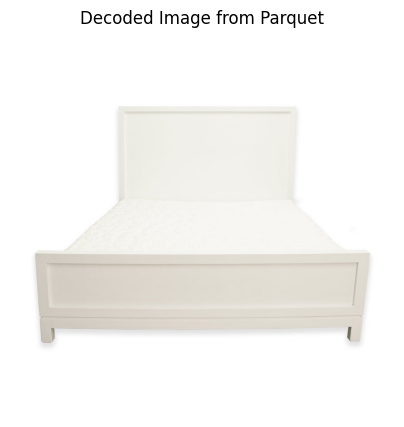

In [8]:
# %%
import pandas as pd
import io
from PIL import Image
import matplotlib.pyplot as plt

# Path to your parquet file
test_path = cfg.out_dir / cfg.out_parquet_name
print("Loading parquet:", test_path)

df_test = pd.read_parquet(test_path)
print("Loaded rows:", len(df_test))
print("Columns:", df_test.columns.tolist())

# Take a random sample
sample = df_test.sample(1, random_state=42).iloc[0]

print("\n=== SAMPLE ROW ===")
print("Source   :", sample['source'])
print("Question :", sample['question'])
print("Answer   :", sample['answer'])

# Decode image bytes
img_bytes = sample["image_bytes"]
img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

# Show image
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title("Decoded Image from Parquet")
plt.show()
